In [21]:
import numpy as np
import control
from control.matlab import *
import matplotlib.pyplot as plt

In [22]:
import pickle as pkl

with open('../data/control/test_set_simple_example_1.pkl', 'rb') as f:
    test_set = pkl.load(f)

data_test = test_set['data_test']
from control.matlab import *

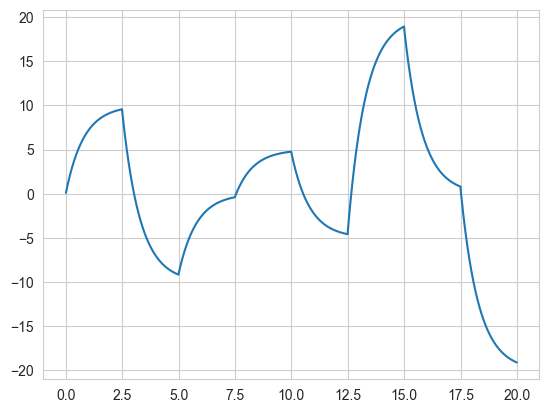

In [96]:
ts = 1e-2
T = 20
t_CL = np.arange(0, T, ts)

# VRFT
s = tf('s')
tau = 5 # s
M = 1/(1 + (tau/(2*np.pi))*s)
M = M*(1 + 1e-2*(tau/(2*np.pi))*s) # add a high freq zero for inversion

r = np.zeros(t_CL.shape)
r[t_CL < 10] = 10
r[(t_CL >= 2.5) & (t_CL < 5)] = -10
r[(t_CL >= 5.0) & (t_CL < 7.5)] = 0
r[(t_CL >= 7.5) & (t_CL < 10)] = 5
r[(t_CL >= 10.) & (t_CL < 12.5)] = -5
r[(t_CL >= 12.5) & (t_CL < 15.)] = 20
r[(t_CL >= 15.0) & (t_CL < 17.5)] = 0
r[(t_CL >= 17.5) & (t_CL < 20.0)] = -20

y_d = lsim(M,r, t_CL)[0]
plt.plot(t_CL, y_d)

u = np.random.normal(0, 1000, t.shape)

In [97]:
import cvxpy as cp

B = [tf([1], [1], dt=ts),
     tf(ts * np.array([1, 1]), 2 * np.array([1, -1]), dt=ts),
     tf(np.array([2, -2]), ts * np.array([3, -1]), dt=ts)]

In [98]:
n_testing = 5
controllers = [None] * n_testing
Y_CL = np.zeros((n_testing, len(u)))
U = np.zeros((n_testing, len(u)))

In [99]:
for n_testing in range(n_testing): #len(data_test)):
        
        print(n_testing)
        data = data_test[n_testing]
        # system
        num = [data['num_1']]
        den = [data['den_1'], data['den_2'], data['den_3']]
        G = tf(num, den)
        
        #first experiment
        u = np.random.normal(0, 1000, t.shape)
        noise1 = np.random.normal(0, 5, t.shape)
        u = lsim(M,u,t)[0]
        y, t, _ = lsim(G, u, t)
        #y = y + noise1
        
        ## virtual reference
        r_v = lsim(M**(-1), y, t)[0]
        e_v = r_v - y
        
        #second experiment
        #u2 = np.random.normal(0, 1000, t.shape)
        #noise2 = np.random.normal(0, 5, t.shape)
        #u2 = lsim(M, u, t)[0]
        #y2, t, _ = lsim(G, u2, t)
        #y2 = y2 + noise2

        ##instrumental variable
        #r_v_iv = lsim(M**(-1), y2, t)[0]
        #iv = r_v_iv - y2
        
    
        theta = cp.Variable(3)
        u_theta = theta[0] * lsim(B[0], e_v, t)[0] + theta[1] * lsim(B[1], e_v, t)[0] + theta[2] * lsim(B[2], e_v, t)[0]
        
        #cost = 1 / len(u) * cp.multiply(iv,(u - u_theta)) 
        cost = u - u_theta
        cost = cp.sum_squares(cost)
        prob = cp.Problem(cp.Minimize(cost))
        prob.solve()
        theta_sol = theta.value
        C = theta_sol[0]*B[0] + theta_sol[1]*B[1] + theta_sol[2]*B[2]
        
        G = c2d(G, ts, 'tustin')
        F = C*G/(1 + C*G)
        y_cl = lsim(F,r,t_CL)[0]
        
        controllers[n_testing] = C
        Y_CL[n_testing] = y_cl
        U[n_testing] = u

0
1
2
3
4


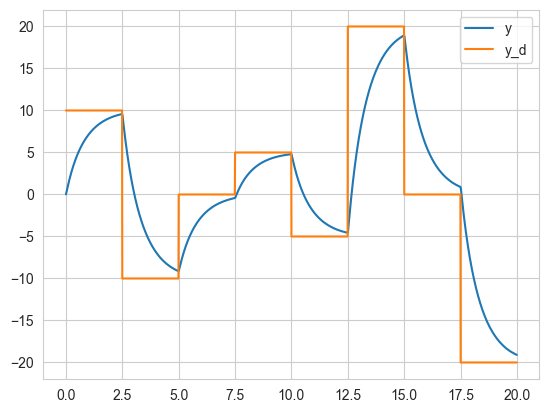

In [101]:
plt.plot(t_CL, Y_CL[2], label='y')
plt.plot(t_CL, r, label='y_d')
plt.legend()
plt.show()

In [103]:
err = y_cl - r
## CALCULATE MSE (r, y) 
error_tot = 0
for k in range(len(err)):
    squared_error = err[k] * err[k]
    error_tot += squared_error 
MSE = error_tot / len(err)
print(f"MSE: {MSE:.5f}")


MSE: 41.63864


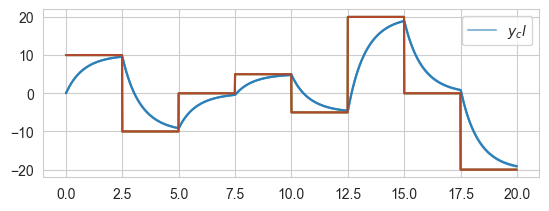

In [102]:
 for i in range(0,n_testing):
        plt.subplot(211)
        plt.plot(t_CL,  Y_CL[i], c='tab:blue', alpha=0.5)
        plt.legend(['$y_cl$'])
        plt.plot(t_CL, r, label='ref', alpha = 0.7)
plt.show()